<h1><center>DALLAS CRIME DATA</center></h1>
<h2><center>MSDS 7331 LAB 3</center></h2>
<h2><center>Clustering Modelling</center></h2>

<h4><center>Team Members</center></h4>

           Yejur Singh Kunwar           Bin Yu               Vivek Viswanathan          Kevin Mendonsa
              Dallas, TX               Dallas, TX               Dallas, TX                Irvine, CA

## Introduction
##### Data Description
The Dallas Crime Incident data set that is used in the Lab 3 acts as a bridge between the citizens of Dallas and the Dallas PD. It represents the Dallas Police Public Data - RMS Incidents from June 1, 2014 to September 7, 2018. 

For purposes of this analysis, the main dataframe has trimmed based on the analysis performed as part of Labs 1 and 2. The details of the data quality clean up and choice of columns have been detailed in the Lab 1 and Lab 2 notebook links provided below.

**Lab 1 Notebook Link -** https://github.com/wtubin/MSDS7331-Data-Mining/MSDS7331_Data_Mining_Lab1_Data-Viz_Pre-Processing.ipynb

**Lab 2 Notebook Link -** https://github.com/wtubin/MSDS7331-Data-Mining/blob/master/MSDS7331_Data_Mining_Lab2_Classification.ipynb

The data set currently has 200,780 rows and 50 columns.

**Note -** The structure of the document will closely follow the phases of the CRISP-DM Modeling Phase.

##### Objective

The objective of this unit is to perform clustering on an unlabeled dataset to provide insight or features. 

As part of this Lab, we will:
- Choose a subset of features from the dataset to cluster upon
- Cluster the features assuming according to a given algorithm
- Replace the features with their discrete cluster labels as a form of discretization
- Perform classification using the new feature from the dataset

**GitHub Repository containing the artifacts -** https://github.com/wtubin/MSDS7331-Data-Mining

**Location of the raw (compressed) data file -** https://github.com/wtubin/MSDS7331-Data-Mining/Police_Incidents.7z 

# Do we need this?
### Modeling Assumptions
For purposes of our classification, we have performed the following transformations to ensure:
 * All features are uniformly distributed with 0 mean and unit variance
 * Features are resampled to ensure that the response variables are balanced
 * Multi-collinearity has been addressed
 * Features have been converted to categories, where applicable, to improve model efficiency.

# Data Understanding Part 1

### Data Preparation

The dataset is loaded into the workspace as a data frame and undergoes transformation or standardization before being used into model. The attributes that do not contribute adequately in predicting the response variable have been excluded.  

Going forward, we will refer to the Explanatory variables as Features.

The dataset is split into explanatory, for running the models.

   - inci_X : Explanatory variables (Features)
   - inci_Y : Response variable (Arrest_status)

The Features have been scaled to a mean of 0 and variance of 1 to improve accuracy of the classification models. The data will be split into 80/20 train-test set. 

Correlation scores, variance inflation factors (VIFs) and feature significance have been leveraged for dimensionality reduction. The remaining features will be utilized in our models: K-means++, HAC and DBSCAN Clustering methodologies.

The following techniques have been used during the analysis to improve the performance and accuracy.
 - Class balancing using down sampling
 - Multi-collinearity was identified and addressed using  
     - Correlation Matrix
     - VIF
 - Scaling the features
 - Cross Validation was implemented using the following techniques 
     - Shuffle Split
     - Stratified Shuffle Split
     - Stratified K Split
 
A brief description of the purpose and outcome of each of the techniques is explained as they are being applied to the data set.

In [1]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import plotly.tools as tls
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

In [2]:
# Importing data from Lab#1 and exploring the data, the csv file is the result dataset from Lab1
path = '../Data/'# Generic path
incident = pd.read_csv(path + '\\LAB1_completed_Dataset_clean_new.csv', low_memory= False)

#### Data Clean up, standardization, and categorical feature creation

In [3]:
# Exploring the dataset
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)

# 0-11 (Emergency), 11-31(Urgent), 31-60(Important), (60-max)(Non_Urgent)
incident['Res_time_category'] = pd.cut(incident.Response_time,[0,11,31,60,1e6],2,labels=[0,1,2,3])
incident = incident[incident['Res_time_category'].isnull()==False]
incident = incident[incident['Call_Received_Hour'].isnull()==False]

# Further cleanup the dataset
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]

# Further data clean up of feature variables
incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

# Setup the UCR Offense Name Groups
THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    
# Regroup the UCR_Offense_Name
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

# Change nominal attributes to numeric
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']
incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)

# Coding
incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes
# Added UCR_Offense_Description
incident['UCR_Offense_Description'] = pd.Categorical(incident['UCR_Offense_Description']).codes
incident['Res_time_category'] = pd.Categorical(incident['Res_time_category']).codes

In [6]:
# Print out the data properties
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]
print(incident.shape)
print('Number of null columns and their counts')
print(incident_NullCols)

(200780, 50)
Number of null columns and their counts
Type_Location                3545
Reporting_Area                122
Beat                           51
Sector                         51
Call_Cleared_Date_Time        134
Call_Dispatch_Date_Time        18
Offense_Status                363
Victim_Condition           183709
Family_Offense                 27
Weapon_Used                 21303
UCR_Code                    11065
X_Coordinate                15809
Y_Coordinate                15809
State                         480
Call_Cleared                  134
Call_Dispatch                  18
Latitude                     7716
Longitude                    7716
dtype: int64


In [7]:
def get_unixtime(time):    
    return (time.astype(np.int64)/1e6).astype(np.int64)

import time
incident['Call_Received_Date_Time'] = pd.to_datetime(incident['Call_Received_Date_Time'])
incident['Call_Cleared_Date_Time'] = pd.to_datetime(incident['Call_Cleared_Date_Time'])
incident['Call_Dispatch_Date_Time'] = pd.to_datetime(incident['Call_Dispatch_Date_Time'])

incident['Call_Received_Date_Time_epoch']= get_unixtime(incident['Call_Received_Date_Time'])
incident['Call_Cleared_Date_Time_epoch']=get_unixtime(incident['Call_Cleared_Date_Time'])
incident['Call_Dispatch_Date_Time_epoch']=get_unixtime(incident['Call_Dispatch_Date_Time'])

In [8]:
# Drop columns that do not contribute towards our model
incident = incident.drop(['Incident_Number_w/year','Year_of_Incident', 'Service_Number_ID', 'Type_of_Incident','Type_Location', 
                          'Reporting_Area', 'Beat', 'Sector','Council_District','Call_Received_Date_Time',
                          'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time','Person_Involvement_Type', 
                          'Victim_Gender', 'Offense_Status', 'Victim_Condition','Family_Offense', 'Weapon_Used', 
                          'RMS_Code', 'UCR_Code', 'Zip_Code', 'City', 'State',
                          'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch','Latitude', 'Longitude','Unnamed: 0'
                          #,'X_Coordinate', 'Y_Coordinate'
                         #,'Call_Received_Date_Time_epoch', 'Call_Cleared_Date_Time_epoch','Call_Dispatch_Date_Time_epoch'
                         ],axis=1)



In [9]:
# Null values have been removed. we are having a big dataset. It should be fine just drop the null (NA) values from the dataset.
incident= incident.dropna()

In [10]:
incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184971 entries, 0 to 255153
Data columns (total 23 columns):
Watch                            184971 non-null int64
Division                         184971 non-null int8
Day1_of_the_Week                 184971 non-null int8
Victim_Type                      184971 non-null int8
Victim_Race                      184971 non-null int8
Victim_Age                       184971 non-null int32
Hate_Crime                       184971 non-null int64
Gang_Related_Offense             184971 non-null int64
Drug_Related                     184971 non-null int64
UCR_Offense_Name                 184971 non-null int8
X_Coordinate                     184971 non-null float64
Y_Coordinate                     184971 non-null float64
UCR_Offense_Description          184971 non-null int8
Number_of_offense                184971 non-null int32
Response_time                    184971 non-null int32
Arrest_status                    184971 non-null int64
Call_Receiv

### Response Variable Analysis

As part of this analysis, we look at the distinct values and distribution of the response variable. 

- Arrest status
    - 0 = Arrest not made
    - 1 = Arrest made


Class 0: 166451
Class 1: 18520


<Figure size 576x360 with 0 Axes>

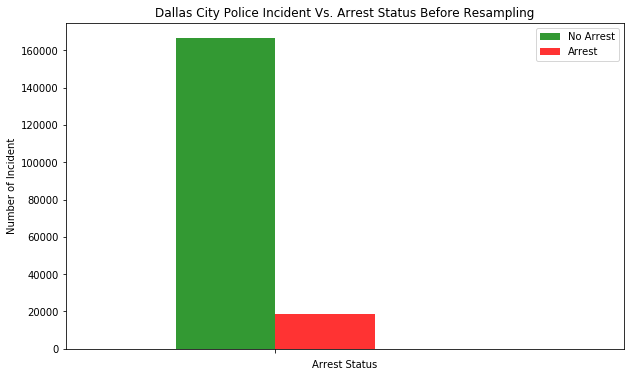

In [11]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Plot bar graph

# Data to plot
n_groups = 1
NoArrest=incident.Arrest_status.value_counts()[0]
Arrest=incident.Arrest_status.value_counts()[1]
 
# Create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

### Resampling (Downsampling) the data set

Based on the above analysis, we have an unbalanced proportion of samples arrests made versus to arrests not made. 

In an unbalanced class, we cannot reliably use accuracy to measure performance. This makes training the model very tricky. The model may predict the majority class better and sometimes ignore the minority class completely. There are 2 ways to balance the data set: downsampling and upsampling. We selected the downsampling as we have a sufficiently large dataset.

We performed down-sampling by 
1. Separating observations based on class
2. Resample the majority class without replacement after setting the number of samples to match the minority class count
3. Concatenated the down-sampled majority class with the original minority class

We plotted the distribution of the response variable classes to ensure that it is balanced before proceeding with further analysis.

Source: https://elitedatascience.com/imbalanced-classes

In [12]:
# Import resample package
from sklearn.utils import resample

# Downsampling
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=18520,  # to match minority class
                                     random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()

1    18520
0    18520
Name: Arrest_status, dtype: int64

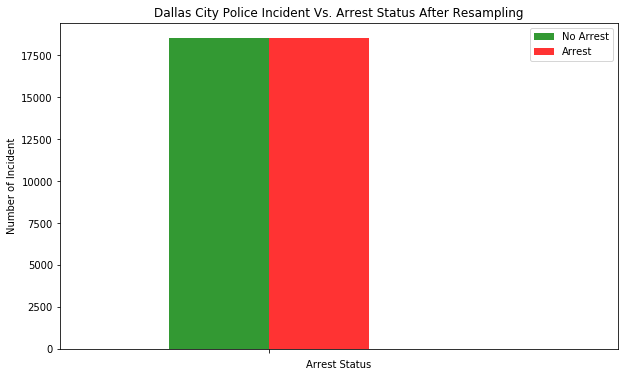

In [13]:
n_groups = 1
NoArrest=df_downsampled.Arrest_status.value_counts()[0]
Arrest=df_downsampled.Arrest_status.value_counts()[1]
 
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, 
        NoArrest, 
        bar_width,
        alpha=opacity,
        color='g',
        label='No Arrest')
 
plt.bar(index + bar_width, 
        Arrest, 
        bar_width,
        alpha=opacity,
        color='r',
        label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
#plt.tight_layout()
plt.show()

In [14]:
# copy the down sampled dataset to the original incident data frame and continue the analysis
incident= df_downsampled.copy()

##### Collinearity

As part of Lab 1 data exploration, we identified that some attributes in the original dataset appeared to be highly collinear. In other words, one predictor variable in the regression model can be linearly predicted from the others with a substantial degree of accuracy.

During this exercise, additional collinearity was introduced because:
 * Continuous Variables were converted to Categorical variables (e.g. Response Time & Victim Age were converted to Categorical)
 * Derived Features based on (or a combination of) values of existing features (e.g. Social Crime Score)
 * Identical features where one was a roll up of the other (e.g. Watch & Call Received Hour)
 
Based on the analysis of the Correlation Matrix, we dropped one or more features from the pairs that were highly correlated.

In [15]:
# Create Correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)

# REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Res_time_category        Response_time              0.955328
Drug_Related             Social_crime_score         0.841239
Watch                    Call_Received_Hour         0.732130
UCR_Offense_Description  UCR_Offense_Name           0.690865
Social_crime_score       Gang_Related_Offense       0.565914
                                                      ...   
Arrest_status            Response_time             -0.179920
                         UCR_Offense_Description   -0.244570
Victim_Race              Division                  -0.285132
Arrest_status            UCR_Offense_Name          -0.311077
Division                 Y_Coordinate              -0.632288
Length: 253, dtype: float64


# Data Understanding Part 2

In [16]:
incident.describe()

,Watch,Division,Day1_of_the_Week,Victim_Type,Victim_Race,Victim_Age,Hate_Crime,Gang_Related_Offense,Drug_Related,UCR_Offense_Name,...,Number_of_offense,Response_time,Arrest_status,Call_Received_Hour,Res_time_category,IsMale,Social_crime_score,Call_Received_Date_Time_epoch,Call_Cleared_Date_Time_epoch,Call_Dispatch_Date_Time_epoch
count,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,...,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,37040.000000,3.704000e+04,3.704000e+04,3.704000e+04
mean,2.068359,3.207775,2.946841,2.000000,3.355886,38.370680,0.000459,0.005643,0.013850,2.541172,...,1.125702,18.298974,0.500000,12.839606,0.703024,0.530211,0.019951,1.464157e+12,1.457539e+12,1.463006e+12
std,0.822300,1.980063,1.988997,0.016431,1.632117,14.236969,0.021419,0.074906,0.116869,2.239604,...,0.549323,22.031901,0.500007,6.505660,0.958116,0.499093,0.143833,3.614800e+10,2.686831e+11,1.167932e+11
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.401572e+12,-9.223372e+12,-9.223372e+12
25%,1.000000,2.000000,1.000000,2.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,3.000000,0.000000,8.000000,0.000000,0.000000,0.000000,1.433790e+12,1.433767e+12,1.433786e+12
50%,2.000000,3.000000,3.000000,2.000000,3.000000,35.000000,0.000000,0.000000,0.000000,3.000000,...,1.000000,8.000000,0.500000,13.000000,0.000000,1.000000,0.000000,1.462973e+12,1.462954e+12,1.462972e+12
75%,3.000000,5.000000,5.000000,2.000000,6.000000,48.000000,0.000000,0.000000,0.000000,5.000000,...,1.000000,25.000000,1.000000,18.000000,1.000000,1.000000,0.000000,1.493808e+12,1.493803e+12,1.493810e+12
max,3.000000,7.000000,6.000000,3.000000,6.000000,89.000000,1.000000,1.000000,1.000000,6.000000,...,22.000000,97.000000,1.000000,23.000000,3.000000,1.000000,2.000000,1.536308e+12,1.536317e+12,1.536311e+12


**Features from Original data set:**

<p align="left">Attribute</p>|<p align="left">Data Type</p>|<p align="left">Description</p> 
:--------- | :----------------- | :-------------               
<p align="left">Watch</p>|Norminal|<p align="left">Police watch 1st 2nd or 3rd (1st watch = Late Night, 2nd watch = Days and 3rd watch = Evenings)</p>
<p align="left">Division</p>|Norminal|<p align="left">Geographic area comprised of census blocks where incident occurred </p>
<p align="left">Day1_of_the_Week</p>|Interval|<p align="left">Day of the indent based on the Date of Occurrence (Date1). Internal use</p>
<p align="left">Victim_Type</p>|Norminal|<p align="left">Victim Type</p>
<p align="left">Victim_Race</p>|Norminal|<p align="left">Victim Race</p>
<p align="left">Victim_Age</p>|Ratio|<p align="left">Victim Age</p>
<p align="left">Hate_Crime</p>|Interval|<p align="left">Yes or no if offense is a hate crime. We keep this attribute as we may find useful information in it</p>
<p align="left">Gang_Related_Offense</p>|Interval|<p align="left">Yes or no if offense is gang realated</p>
<p align="left">Drug_Related_Incident</p>|Interval|<p align="left">Yes or no if incident is drug related</p>
<p align="left">UCR_Offense_Name</p>|Norminal|<p align="left">UCR Offense Name</p>
<p align="left">X_Coordinate</p>|Interval|<p align="left">X Coordinate</p>
<p align="left">Y_Coordinate</p>|Norminal|<p align="left">Y Coordinate</p>
<p align="left">UCR_Offense_Description</p>|Norminal|<p align="left">UCR Offense Description</p>

#### Features Created by transforming existing features:

<p align="left">Attribute</p>|<p align="left">Data Type</p>|<p align="left">Description</p>  
:--------- | :----------------- | :-------------               
<p align="left">Number_of_offense</p>|Interval|<p align="left">Number of Offense, calculated attribute</p>
<p align="left">Response_time</p>|Interval|<p align="left">Response time, calculated attribute.</p>
<p align="left">Arrest_status</p>|Interval|<p align="left">Arrest or No Arrest, calculated attribute.</p>
<p align="left">Call_Received_Hour</p>|Interval|<p align="left">Call Received Hours, calculated attribute</p>
<p align="left">IsMale</p>|Interval|<p align="left">Is Male or Not, calculate from the Victim Gender, calculated attribute</p>
<p align="left">Social_crime_score</p>|Interval|<p align="left">Social crime score, calculated attribute from Gang_Related_Offense, Drug_Related_Incident</p>
<p align="left">Call_Received_Date_Time_epoch</p>|Interval|<p align="left">Call Received Time with numeric format, calculated attribute</p>
<p align="left">Call_Cleared_Date_Time_epoch</p>|Interval|<p align="left">Call Cleared Time with numeric format, calculated attribute</p>
<p align="left">Call_Dispatch_Date_Time_epoch</p>|Interval|<p align="left">Call Dispatch Time with numeric format, calculated attribute</p>
<p align="left">Res_time_category</p>|Interval|<p align="left">Response Time Category, calculated attribute</p>

### Splitting data set into Response and Explanatory Variables 

In [17]:
incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37040 entries, 111777 to 255143
Data columns (total 23 columns):
Watch                            37040 non-null int64
Division                         37040 non-null int8
Day1_of_the_Week                 37040 non-null int8
Victim_Type                      37040 non-null int8
Victim_Race                      37040 non-null int8
Victim_Age                       37040 non-null int32
Hate_Crime                       37040 non-null int64
Gang_Related_Offense             37040 non-null int64
Drug_Related                     37040 non-null int64
UCR_Offense_Name                 37040 non-null int8
X_Coordinate                     37040 non-null float64
Y_Coordinate                     37040 non-null float64
UCR_Offense_Description          37040 non-null int8
Number_of_offense                37040 non-null int32
Response_time                    37040 non-null int32
Arrest_status                    37040 non-null int64
Call_Received_Hour     

In [18]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']
# Features with no predictive features with respect to response variable 
# Also dropping highly correlated attributes
inci_X = incident.drop(['Arrest_status', 'Res_time_category', 'Drug_Related', 'Watch'],axis=1)

from sklearn.preprocessing import StandardScaler
#Scale data
scaler = StandardScaler()
inci_X_scaled = scaler.fit_transform(inci_X)
#Save as data frames
df_inci_X_scaled = pd.DataFrame(inci_X_scaled)

In [19]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(inci_X.values, i) for i in range(inci_X.shape[1])]
df2_vif["features"] = inci_X.columns
print("VIF Factors before Scaling")
df2_vif

VIF Factors before Scaling


,VIF Factor,features
0,1.186792,Division
1,1.001998,Day1_of_the_Week
2,0.876084,Victim_Type
3,1.131458,Victim_Race
4,1.023716,Victim_Age
5,1.033949,Hate_Crime
6,1.492941,Gang_Related_Offense
7,1.949590,UCR_Offense_Name
8,0.871385,X_Coordinate
9,0.426452,Y_Coordinate


In [20]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(df_inci_X_scaled.values, i) for i in range(df_inci_X_scaled.shape[1])]
df2_vif["features"] = df_inci_X_scaled.columns
print("VIF Factors after Scaling")
df2_vif

VIF Factors after Scaling


,VIF Factor,features
0,1.761594,0
1,1.002003,1
2,1.000429,2
3,1.135227,3
4,1.024055,4
5,1.033955,5
6,1.493084,6
7,1.953529,7
8,1.030180,8
9,1.695376,9


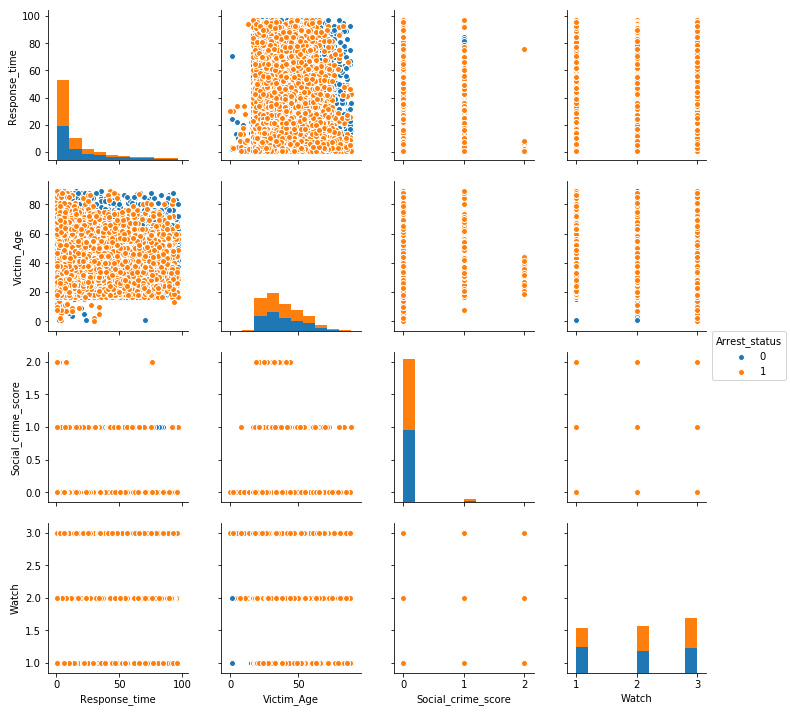

In [21]:
sns.pairplot(incident.dropna()
             , vars=['Response_time', 'Victim_Age', 'Social_crime_score','Watch']
             , hue='Arrest_status')

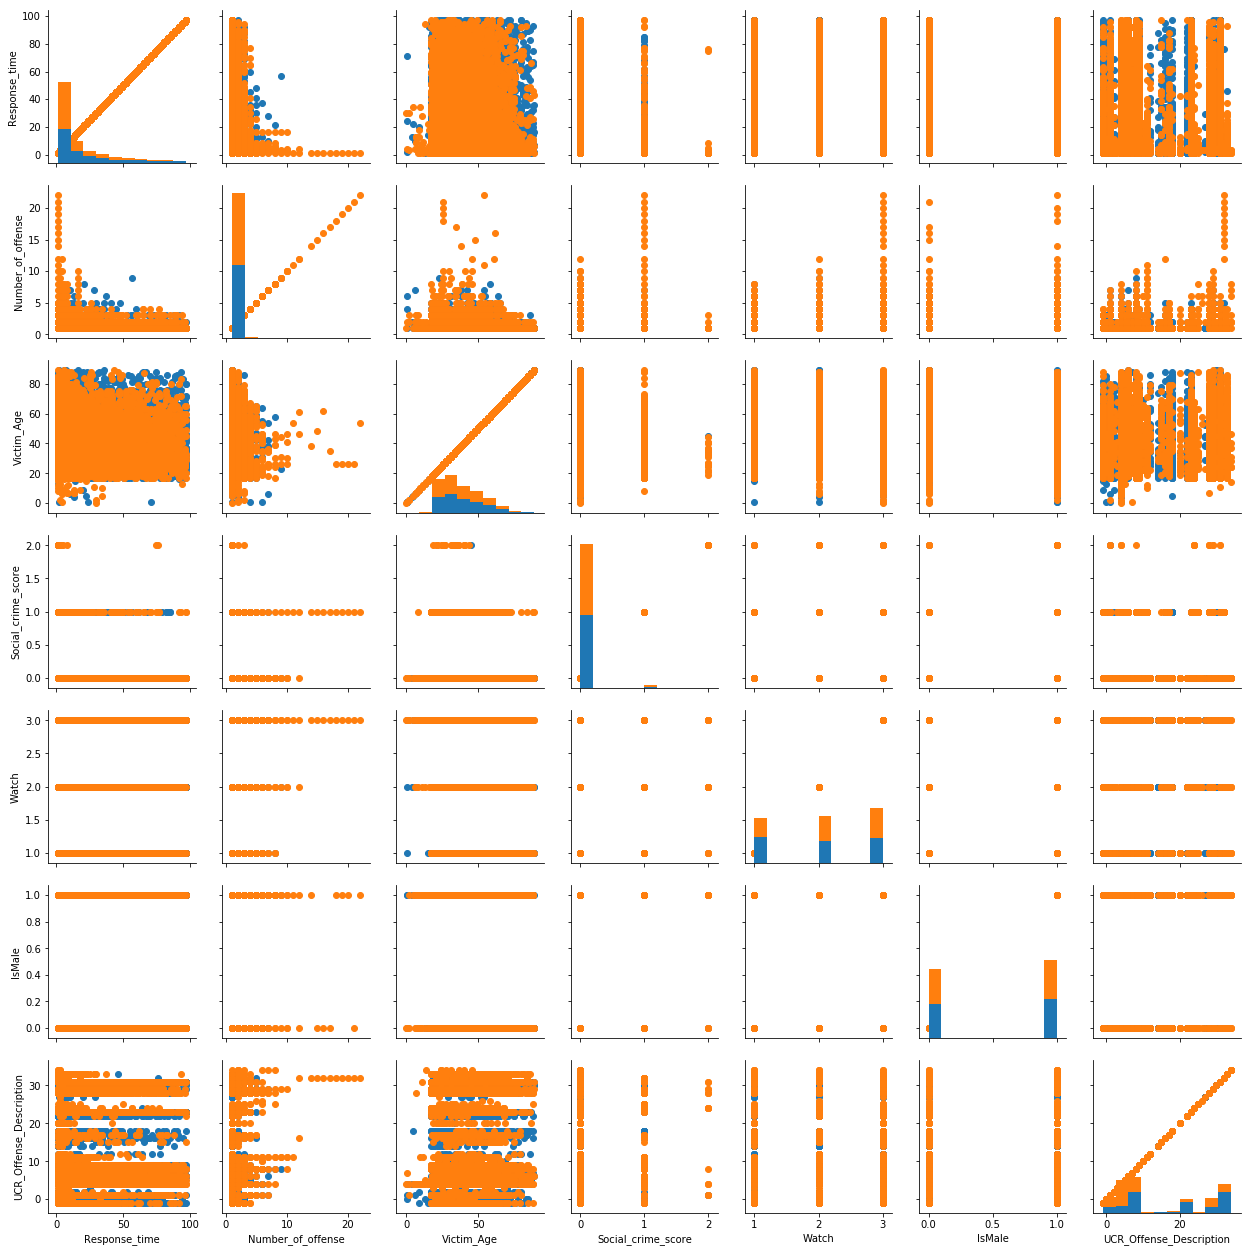

In [23]:
g = sns.PairGrid(incident, vars=['Response_time','Number_of_offense' ,'Victim_Age', 'Social_crime_score','Watch','IsMale','UCR_Offense_Description']
             , hue='Arrest_status')
g = g.map_diag(plt.hist)
g = g.map(plt.scatter)

- From the results of the pair pot. Response time, number of offense, Victim Age, UCR_Offense_Description have some relationship with arrest status. In each plot the color Blue is represent None-Arrest Made, on the other hand, green is represent Arrest Made.

In [22]:
# sns.pairplot(incident.dropna()
#              , vars=['Response_time', 'Victim_Age', 'Social_crime_score','Watch']
#              , hue='Res_time_category')

## Cluster map

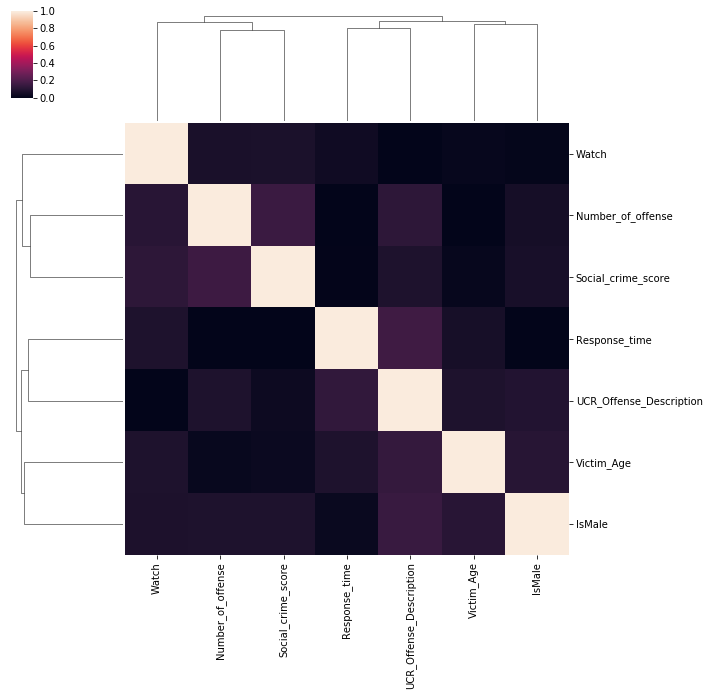

In [24]:
# Clustermap
cls = incident[['Response_time','Number_of_offense' ,'Victim_Age', 'Social_crime_score','Watch','IsMale','UCR_Offense_Description']]
sns.clustermap(cls.corr(), standard_scale=1)
plt.show()

- The heat map shows the data value for each row and column (possibly standardized so they all fit in the same range). Any patterns in the heat map may indicate an association between the rows and the columns. Or you might be able to modify the clustering to create patterns.

- The main pattern to look for is a rectangular area of about the same color. That suggests a group of rows that is correlated for the corresponding group of columns. For instance, several columns show a lot of darker than average values.

- From the cluster heat map above, looks like watch, Number of Offense and social crime score are clustering. Response_time, UCR Offense Description are clustering. Victim Age and IsMale are clustering. 

# Modeling and Evaluation 1

In [25]:

from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
# import hdbscan
from sklearn.manifold import spectral_embedding
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib as mpl
from PIL import Image
import itertools
from scipy import linalg
from sklearn.metrics import pairwise

In [26]:
##### Preparing dataset for clusturing
incident.columns

Index(['Watch', 'Division', 'Day1_of_the_Week', 'Victim_Type', 'Victim_Race',
       'Victim_Age', 'Hate_Crime', 'Gang_Related_Offense', 'Drug_Related',
       'UCR_Offense_Name', 'X_Coordinate', 'Y_Coordinate',
       'UCR_Offense_Description', 'Number_of_offense', 'Response_time',
       'Arrest_status', 'Call_Received_Hour', 'Res_time_category', 'IsMale',
       'Social_crime_score', 'Call_Received_Date_Time_epoch',
       'Call_Cleared_Date_Time_epoch', 'Call_Dispatch_Date_Time_epoch'],
      dtype='object')

In [27]:
# Results of models, later retrieve as dataframe
classResults = []
clustResults = []

- Modeling and Evaluation 1
    - Train and adjust parameters
- Modeling and Evaluation 2
    - Evaluate and Compare
- Modeling and Evaluation 3
    - Visualize Results
- Modeling and Evaluation 4
    - Summarize the Ramifications

# Modeling and Evaluation 1
## Train and adjust parameters

### Cross Validation 
#### Stratified K Fold
In stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, this means that each fold contains roughly the same proportions of the two types of class labels.

### RANDOM FORESTS
Source: https://www.datascience.com/resources/notebooks/random-forest-intro

Random forests, also known as random decision forests, are a popular ensemble method to build predictive models for both classification and regression. The ensemble methods uses multiple learning models to gain better predictive results — in the case of a random forest, the model creates an entire forest of random uncorrelated decision trees to arrive at the best possible answer.

Decision trees are simple but intuitive models that utilize a top-down approach in which the root node creates binary splits until a certain criteria is met. This binary splitting of nodes provides a predicted value based on the interior nodes leading to the terminal (final) nodes. In a classification context, a decision tree will output a predicted target class for each terminal node produced.

Source: https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#workings
##### Features of Random Forests
- Unexcelled in accuracy among current algorithms.
- Runs efficiently on large data bases.
- Can handle thousands of input variables without variable deletion.
- Provides estimates of what variables are important in the classification.
- Generates an internal unbiased estimate of the generalization error as the forest building progresses.
- Effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
- Includes methods for balancing error in class population unbalanced data sets.
- Generated forests can be saved for future use on other data.
- Prototypes are computed that give information about the relation between the variables and the classification.
- Computes proximities between pairs of cases that can be used in clustering, locating outliers, or (by scaling) give interesting views of the data.
- Capabilities of the above can be extended to unlabeled data, leading to unsupervised clustering, data views and outlier detection.
- Offers an experimental method for detecting variable interactions.

##### Limitations to Decision Trees
Decision trees tend to have high variance when they utilize different training and test sets of the same data, since they tend to overfit on training data. This leads to poor performance on unseen data. Unfortunately, this limits the usage of decision trees in predictive modeling. However, using ensemble methods, we can create models that utilize underlying decision trees as a foundation for producing powerful results.

### Baseline Model - Classification Performance

#### RandomForest Classifier 

##### Parameter Settings
Empirical good default values are max_features=n_features for regression problems, and max_features=sqrt(n_features) for classification tasks (where n_features is the number of features in the data). Good results are often achieved when setting max_depth=None in combination with min_samples_split=2 (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. The best parameter values should always be cross-validated.

###### RandomForestClassifier
- n_estimators: The number of trees in the forest. Value=150

- random_state: Random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random. We used value=1

###### StratifiedKFold
- n_splits: Number of re-shuffling & splitting iterations. We used value = 10

- shuffle : Whether to shuffle each stratification of the data before splitting into batches - False

- random_state: If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np. We have used the random state in the classifier
             
Source: 
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [28]:
%%time 
from sklearn.cluster import KMeans

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y = incident['Arrest_status']
X = incident[['Response_time','Victim_Age','IsMale','Division', 'Victim_Type', 'Victim_Race','UCR_Offense_Description', 'Number_of_offense',
               'Call_Received_Hour','Social_crime_score']]
cv = StratifiedKFold(n_splits=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

classResults.append({'Model': 'Base Classification_StratifiedKFold', 'Type': 'Full' , 'Accuracy': acc.mean()*100, 'Std': acc.std()*100})

Average accuracy =  71.25269978401728 +- 1.837234266400805
Wall time: 46.7 s


- Feature engineering

#### K Means Clustering

The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. Rather than classifying the data based on pre-defined labels, clustering finds and analyzes groups that have formed organically. 

##### Parameter Settings
K Means uses Lloyd's or Elkan's algorithm to identify clusters. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields. K-means is equivalent to the expectation-maximization algorithm with a small, all-equal, diagonal covariance matrix.

In practice, the k-means algorithm is very fast. 

###### K Means Cluster
- n_clusters: The number of clusters to form as well as the number of centroids to generate. Value=8

- random_state: Random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random. We used value=1

Source: 
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html 


        -  Using kmeans on 'Response_time' and 'Number_of_offense'. 

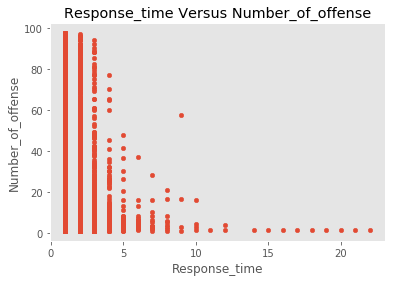

In [29]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
# X1 = incident[['UCR_Offense_Description', 'Victim_Age']].values
X1 = incident[['Response_time', 'Number_of_offense']].values
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('Response_time'), plt.ylabel('Number_of_offense')
plt.grid()
plt.title('Response_time Versus Number_of_offense')
plt.show()

In [31]:
%%time 

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# X1 = incident[['UCR_Offense_Description', 'Victim_Age']]
X1 = incident[['Response_time', 'Number_of_offense']]
cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = incident['Arrest_status']
X = incident[['Victim_Age','IsMale','Division', 'Victim_Type', 'Victim_Race','UCR_Offense_Description', 
              'Call_Received_Hour','Social_crime_score']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for Number_of_offense/Response_time)= ", acc.mean()*100, "+-", acc.std()*100)

classResults.append({'Model': 'Base Classification_KMeans','Type': 'Number_of_offense/Response_time' ,  'Accuracy': acc.mean()*100, 'Std': acc.std()*100})

Average accuracy (with kmeans for Number_of_offense/Response_time)=  69.58963282937364 +- 1.9933549559305739
Wall time: 50.5 s


- Average accuracy of the folds and deviation from mean has remained same.
- Trying to add different discretization of the features.

In [32]:
%%time 

from sklearn.cluster import KMeans
import numpy as np

X2 = incident[['Victim_Age','UCR_Offense_Description', 'Call_Received_Hour','Social_crime_score']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X2)
newfeature = cls.labels_ # the labels from kmeans clustering

y = incident['Arrest_status']
X = incident[['IsMale','Division', 'Victim_Type', 'Victim_Race']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for Age/Offenses)= ", acc.mean()*100, "+-", acc.std()*100)

classResults.append({'Model': 'Base Classification_KMeans','Type': 'Victim_Age/Offenses' ,  'Accuracy': acc.mean()*100, 'Std': acc.std()*100})

Average accuracy (with kmeans for Age/Offenses)=  61.317494600431964 +- 0.8942604109613108
Wall time: 19.2 s


- Increased accuracy 

- Putting together both discretization

In [33]:
# get the first clustering
cls_fare = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = incident['Arrest_status']
X = incident[['IsMale','Division', 'Victim_Type', 'Victim_Race']]
X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

classResults.append({'Model': 'Base Classification_KMeans','Type': 'Victim_Age/Offenses' ,  'Accuracy': acc.mean()*100, 'Std': acc.std()*100})

Average accuracy =  61.43628509719223 +- 0.8594646976704766


In [34]:
#Convert test classification into results list to data frame.
dfclassResults = pd.DataFrame(classResults)
dfclassResults = dfclassResults[['Model', 'Type', 'Accuracy', 'Std']]
dfclassResults.round(2)

,Model,Type,Accuracy,Std
0,Base Classification_StratifiedKFold,Full,71.25,1.84
1,Base Classification_KMeans,Number_of_offense/Response_time,69.59,1.99
2,Base Classification_KMeans,Victim_Age/Offenses,61.32,0.89
3,Base Classification_KMeans,Victim_Age/Offenses,61.44,0.86


##### Varying the parameters

In [35]:
%%time 

X1 = incident[['Response_time', 'Number_of_offense']]

X2 = incident[['Victim_Age','UCR_Offense_Description', 'Social_crime_score']]

params = []
for n_fare in range(4,10):
    for n_fam in range(16,19):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X1)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = incident['Arrest_status']
        X = incident[['IsMale','Division', 'Victim_Type', 'Victim_Race']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("Clusters",n_fare,n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)



Clusters 4 16 Average accuracy =  61.708963282937354 +- 0.4635537805773537
Clusters 4 17 Average accuracy =  61.58477321814255 +- 0.8860434488762984
Clusters 4 18 Average accuracy =  62.03563714902808 +- 0.46367169419067866
Clusters 5 16 Average accuracy =  61.47408207343412 +- 0.5577521170028825
Clusters 5 17 Average accuracy =  61.268898488120946 +- 0.792026632756323
Clusters 5 18 Average accuracy =  61.75755939524837 +- 0.7239499914160695
Clusters 6 16 Average accuracy =  61.3390928725702 +- 0.3738981560964165
Clusters 6 17 Average accuracy =  61.306695464362846 +- 0.7022345302747981
Clusters 6 18 Average accuracy =  61.85205183585314 +- 0.7105101159231656
Clusters 7 16 Average accuracy =  60.86663066954643 +- 0.7186954869635516
Clusters 7 17 Average accuracy =  61.198704103671695 +- 0.8254277816234751
Clusters 7 18 Average accuracy =  61.63066954643629 +- 0.9161620698097225
Clusters 8 16 Average accuracy =  60.92602591792655 +- 0.7149127993533558
Clusters 8 17 Average accuracy =  6

- New method: Best accuracy is around 61.85%. 
- All the models are within one standard deviation of each other, so most clustering in this range are pretty reasonable. 

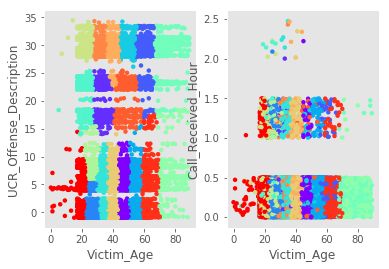

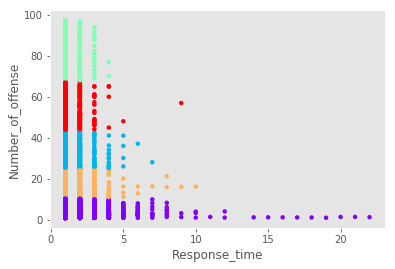

In [36]:
n_fare=5
d_fam=18

X1 = incident[['Response_time', 'Number_of_offense']]
X2 = incident[['Victim_Age','UCR_Offense_Description','Social_crime_score']]

cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

plt.figure()
plt.subplot(1,2,1)
X2=X2.values
plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Victim_Age'), plt.ylabel('UCR_Offense_Description')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X2[:, 0], X2[:, 2]+np.random.random(X2[:, 2].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Victim_Age'), plt.ylabel('Call_Received_Hour')
plt.grid()

X1=X1.values
plt.figure()
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Response_time'), plt.ylabel('Number_of_offense')
plt.grid()

# Modeling and Evaluation 2
- Evaluate and Compare

#### Only one set of cluster dataset final

### KMeans Clustering

In [37]:
%%time 
params = []
for n_fam in range(15,20):

    # append on the clustering
    cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
    cls_fam.fit(X2)
    newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

    y = incident['Arrest_status']
    X = incident[['IsMale','Response_time', 'Number_of_offense']]
    X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

    print ("Clusters",n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
    clustResults.append({'Model':'KMeans',"Clusters":n_fam,"Average accuracy": acc.mean()*100, 'Average Std':acc.std()*100})


Clusters 15 Average accuracy =  61.86015118790497 +- 1.0277670331489208
Clusters 16 Average accuracy =  61.627969762419 +- 1.0764015515302274
Clusters 17 Average accuracy =  61.49298056155508 +- 1.0289719519497706
Clusters 18 Average accuracy =  62.30291576673868 +- 1.1306939138518035
Clusters 19 Average accuracy =  62.05453563714902 +- 1.003306724614274
Wall time: 2min 37s


### AgglomerativeClustering

In [38]:
%%time 

from sklearn.cluster import AgglomerativeClustering

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(13,20):

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = incident['Arrest_status']
        X = incident[['IsMale','Response_time', 'Number_of_offense']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        clustResults.append({'Model':'AgglomerativeClustering',"Clusters":n_fam,"Average accuracy": acc.mean()*100, 'Average Std':acc.std()*100})

C= 13 ward Average accuracy =  61.89524838012959 +- 1.0753955163175606
C= 14 ward Average accuracy =  61.84125269978402 +- 1.0828254479572463
C= 15 ward Average accuracy =  61.72246220302375 +- 0.9872353784035325
C= 16 ward Average accuracy =  61.59827213822895 +- 0.9787378021919838
C= 17 ward Average accuracy =  61.60097192224623 +- 1.0060490753256621
C= 18 ward Average accuracy =  61.44168466522678 +- 1.00639315437304
C= 19 ward Average accuracy =  61.89794816414687 +- 1.03286058837254
C= 13 complete Average accuracy =  61.98434125269979 +- 1.0664283565299333
C= 14 complete Average accuracy =  61.97894168466522 +- 1.1010386534825822
C= 15 complete Average accuracy =  61.868250539956804 +- 1.0420746642698744
C= 16 complete Average accuracy =  61.951943844492455 +- 1.0776197289782061
C= 17 complete Average accuracy =  61.78995680345572 +- 0.9630360813102324
C= 18 complete Average accuracy =  61.71976241900647 +- 1.0218923236277577
C= 19 complete Average accuracy =  61.72246220302377 +-

### DBSCAN

In [39]:
%%time 

from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = incident['Arrest_status']
        X = incident[['IsMale','Response_time', 'Number_of_offense']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        clustResults.append({'Model':'DBSCAN',"Clusters":n_fam,"Average accuracy": acc.mean()*100, 'Average Std':acc.std()*100})

0.1 5 Average accuracy =  65.6182505399568 +- 1.4603435964882254
0.1 6 Average accuracy =  65.38066954643628 +- 1.4425565228407322
0.1 7 Average accuracy =  65.29427645788337 +- 1.398125844317783
0.125 5 Average accuracy =  65.6182505399568 +- 1.4603435964882254
0.125 6 Average accuracy =  65.38066954643628 +- 1.4425565228407322
0.125 7 Average accuracy =  65.29427645788337 +- 1.398125844317783
0.15 5 Average accuracy =  65.6182505399568 +- 1.4603435964882254
0.15 6 Average accuracy =  65.38066954643628 +- 1.4425565228407322
0.15 7 Average accuracy =  65.29427645788337 +- 1.398125844317783
Wall time: 3h 11min 36s


## Modeling and Evaluation 3
-Visualize Results
#### Visualizing clusters

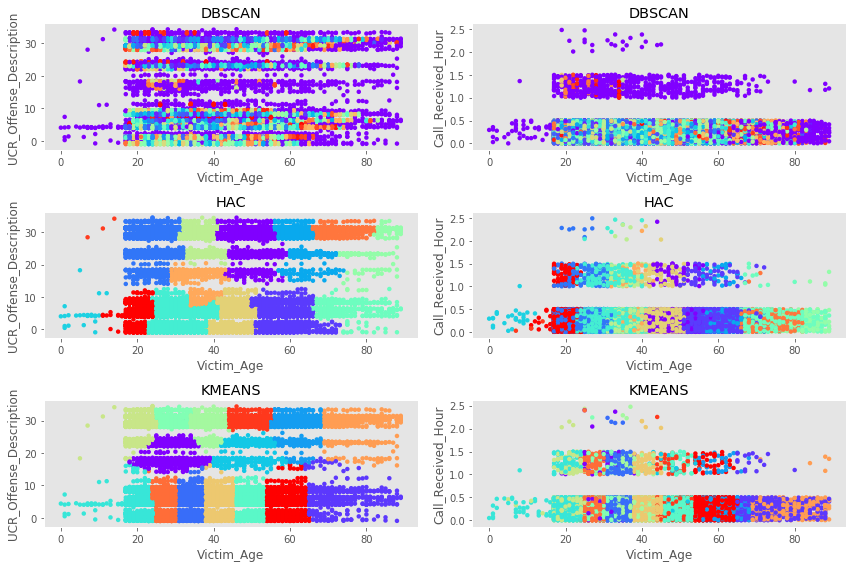

Wall time: 46.3 s


In [40]:
%%time 
data = X2

cls = DBSCAN(eps=0.125, min_samples=6)
cls.fit(data)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=14, linkage='complete')
cls.fit(data)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=15, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Victim_Age'), plt.ylabel('UCR_Offense_Description')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data[:, 0], data[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Victim_Age'), plt.ylabel('Call_Received_Hour')
    plt.grid()
    plt.title(title[i])
    
    


plt.tight_layout()
plt.show()

In [41]:
# this code has been manipulated from the source available on sklearn's website documentation
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

X = X2


lowest_bic = np.infty
bic = []
n_components_range = range(7, 17)
cv_types = ['spherical', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


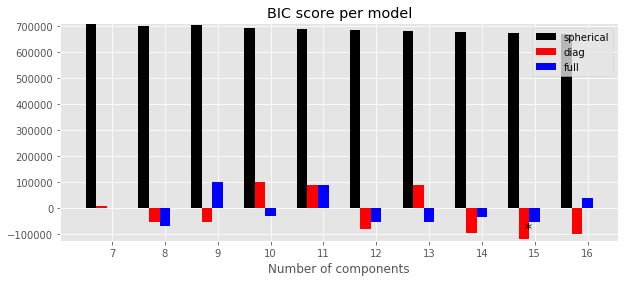

In [42]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

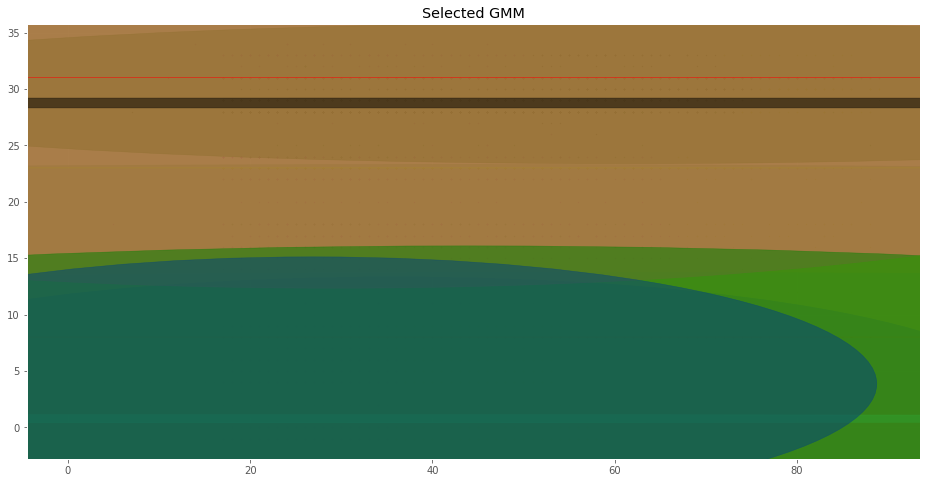

In [43]:
# this code has been manipulated from the source available on sklearn's website documentation
# Plot the winner
plt.figure(figsize=(16,8))
splot = plt.subplot(1,1,1)
Y_ = clf.predict(X)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


plt.title('Selected GMM')
plt.show()

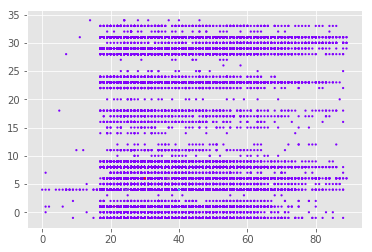

In [44]:
# an example using SpectralClustering, which assumes that the graphical data needs to be calculated from the structure
from sklearn.cluster import SpectralClustering

X = X2
nclust = 10

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = SpectralClustering(n_clusters=nclust, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

In [ ]:
# # an example using SpectralClustering, which assumes that the graphical data needs to be calculated from the structure
# from sklearn.cluster import SpectralClustering

# X = X2
# nclust = 10

# # If a string, this may be one of 
# #  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
# #  or one of the kernels supported by sklearn.metrics.pairwise_kernels
# spc = SpectralClustering(n_clusters=nclust, affinity = 'nearest_neighbors')
# labels = spc.fit_predict(X)

# plt.scatter(X[:, 0], X[:, 2], c=labels,
#                     cmap=plt.cm.rainbow, s=5, linewidths=0)

# plt.show()

In [ ]:
## NEED TO ADD BIC STUFFS 

## Modeling and Evaluation 4
- Summarize the Ramifications

In [64]:
#Convert test classification into results list to data frame.
dfclustResults = pd.DataFrame(clustResults)
dfclustResults = dfclustResults[['Model', 'Clusters', 'Average accuracy', 'Average Std']]
# dfclustResults_1 = dfclustResults.groupby(['Model','Clusters','Average Std'], as_index=False)['Average accuracy'].max()
# dfclustResults.round(2)
dfclustResults_1 = dfclustResults.groupby(['Model'], as_index=False)['Average accuracy'].max()
dfclustResults_1 = dfclustResults_1.merge(dfclustResults, how='left', on=['Model', 'Average accuracy'])
dfclustResults_2 = dfclustResults_1[dfclustResults_1.duplicated(subset='Model', keep='first')==False]
dfclustResults_2.round(2)

,Model,Average accuracy,Clusters,Average Std
0,AgglomerativeClustering,62.80,14,1.10
1,DBSCAN,65.62,19,1.46
4,KMeans,62.30,18,1.13


# OTHER SECTION

###### END OF REPORT